In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn
import PIL
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [5]:
assert torch.__version__=='1.8.1'

In [6]:
np.random.seed(0)
torch.manual_seed(0)

#### input shape [batch, H, W, C=1]
#### output shape [batch, H, W, 3 * nr mix]

In [7]:
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transforms.ToTensor())
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transforms.ToTensor())

In [8]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64)
test_loader = torch.utils.data.DataLoader(testset,batch_size=64)

In [9]:
# masked CNN
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [10]:
# model
class PixelCNN(nn.Module):
    n_channels = 4
    kernel_size = 7
    padding = 3
    #n_pixels_out = 2 # binary 0/1 pixels
    #nr_mix
    
    def __init__(self, nr_mix):
        super(PixelCNN, self).__init__()
        self.nr_mix = nr_mix
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=1, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=3*self.nr_mix, kernel_size=1)
        )
        
    def forward(self, x):
        x = self.layers(x) # shape  = [batch, 3*nr_mix, H, W]
        softmax = nn.Softmax(dim=1)
        softplus = nn.Softplus()
        sigmoid = nn.Sigmoid()

        mu =  x[:, :self.nr_mix, :, :]
        var = x[:, self.nr_mix:2*self.nr_mix, :, :]
        pi_mix = x[:, 2*self.nr_mix:3*self.nr_mix, :, :]
        
        mus = torch.empty(mu.shape)
        mus[:, 0, :, :] = mu[:, 0, :, :]
        for i in range(2, self.nr_mix):
            mus[:, i, :, :] = mus[:, i-1, :, :] + softplus(mu[:, i, :, :])

        mus = sigmoid(mus)
        var = softplus(var)
        var = torch.clamp(var, min=0.00000001)
        pi_mix = softmax(pi_mix)
        
        x = torch.cat((mus, var, pi_mix), dim=1)

        return x


In [12]:
def Mixture_Gauss_NLLLoss(target, pred): # mu, sigma, pi_mix):
    total_lik = 0#torch.zeros(target[:,0,:,:].shape)
    loss_func  = nn.GaussianNLLLoss(full=False, reduction='none')
    #sigma = torch.clamp(sigma, 0.000001)
    nr_mix = int(pred.shape[1]/3)
    
    mu =  pred[:, :nr_mix, :, :]
    var = pred[:, nr_mix:2*nr_mix, :, :]
    pi_mix = pred[:, 2*nr_mix:3*nr_mix, :, :]
    var = torch.clamp(var,min=0.0000001)

    for i in range(nr_mix):

        loss = loss_func(torch.flatten(mu[:,i,:,:]), torch.flatten(target[:,0,:,:]), torch.flatten(var[:,i,:,:]))
        #print(loss.shape)
        likelihood = torch.exp(-loss)
        #print(target[:,0,:,:].shape)
        #print(likelihood.shape)
        #print(pi_mix[:,i,:,:].shape)
        #print(torch.flatten(pi_mix[:,i,:,:]).shape)
        total_lik += torch.flatten(pi_mix[:,i,:,:])*likelihood #sum , mean????

    
    gauss_mix_loss = torch.log(torch.clamp(total_lik, min=0.00000001))
    
    return -gauss_mix_loss.mean() 

In [13]:
#loss func
pixel_cnn = PixelCNN(nr_mix=3)
loss_function  = Mixture_Gauss_NLLLoss
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=0.0005)

In [255]:
epochs = 20
loss_vals_train = []
loss_vals_test = []

In [257]:
#torch.autograd.set_detect_anomaly(False)

In [258]:
for e in range(epochs): # 5 epochs at maximum
    #torch.autograd.detect_anomaly()
    # Print epoch
    print(f'Starting epoch {e+1}')
    
    # Set current loss value
    current_loss = 0.0

    for im, _ in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        pred_mix = pixel_cnn(im)

        loss = loss_function(im, pred_mix)

        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss += loss.item()

    print('Loss after mini-batch %5d: %.3f' %
                (e + 1, current_loss / len(train_loader)))    
    
    validation_loss = 0.0
    pixel_cnn.eval()
    for im, _ in test_loader:
        pred_mix = pixel_cnn(im)
        loss_val = loss_function(im, pred_mix)
        validation_loss += loss_val.item()

    print('Val Loss after mini-batch %5d: %.3f' %
                (e + 1, validation_loss / len(test_loader)))

    # Process is complete.
    loss_vals_train.append(current_loss/len(train_loader))
    loss_vals_test.append(validation_loss/len(test_loader))

print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: -0.704
Val Loss after mini-batch     1: -1.581
Starting epoch 2
Loss after mini-batch     2: -3.935
Val Loss after mini-batch     2: -4.016
Starting epoch 3
Loss after mini-batch     3: -4.109
Val Loss after mini-batch     3: -4.051
Starting epoch 4
Loss after mini-batch     4: -4.137
Val Loss after mini-batch     4: -4.065
Starting epoch 5
Loss after mini-batch     5: -4.157
Val Loss after mini-batch     5: -4.057
Starting epoch 6
Loss after mini-batch     6: -4.177
Val Loss after mini-batch     6: -4.043
Starting epoch 7
Loss after mini-batch     7: -4.192
Val Loss after mini-batch     7: -4.044
Starting epoch 8
Loss after mini-batch     8: -4.202
Val Loss after mini-batch     8: -4.048
Starting epoch 9
Loss after mini-batch     9: -4.210
Val Loss after mini-batch     9: -4.054
Starting epoch 10
Loss after mini-batch    10: -4.216
Val Loss after mini-batch    10: -4.068
Starting epoch 11
Loss after mini-batch    11: -4.222
Val Loss after 

In [309]:
torch.save(pixel_cnn.state_dict(), 'pixel_cnn_test.pt')

In [14]:
pixel_cnn.load_state_dict(torch.load('pixel_cnn_test.pt'))
pixel_cnn.eval()

PixelCNN(
  (layers): Sequential(
    (0): MaskedConv2d(1, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(4, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

Text(0.5, 1.0, 'loss')

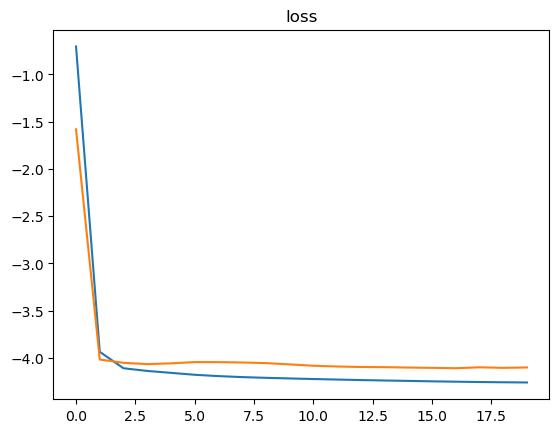

In [259]:
plt.plot(range(len(loss_vals_train)),loss_vals_train)
plt.plot(range(len(loss_vals_test)),loss_vals_test)
plt.title('loss')

In [15]:
from scipy.stats import truncnorm

/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
fashion_imgs_train = torch.load('MNIST_data/FashionMNIST/processed/training.pt')
fashion_imgs_test = torch.load('MNIST_data/FashionMNIST/processed/test.pt')

In [155]:
fashion_imgs_test[0][2:3].shape

torch.Size([1, 28, 28])

In [37]:
def gen_im_mix_trunc(model, im_size, nbh_size):
    m, n = nbh_size
    
    #new_im = np.zeros(im_size)
    #new_im = torch.zeros(im_size)
    #new_im = torch.full(im_size, 100.0)
    #new_im = torch.randint(low=50, high=150, size=im_size,dtype=torch.float)
    
    #new_im = torch.rand(im_size)-0.5 # prøv med 0.5
    #new_im = torch.full(im_size,0.5)
    pred_mu = np.zeros(im_size)
    pred_sigma2 = np.zeros(im_size)
    pred_mu2 = np.zeros(im_size)
    pred_sigma2_2 = np.zeros(im_size)
    pred_pi_mix = np.zeros(im_size)

    new_im = torch.unsqueeze(fashion_imgs_test[0][2:3]/255, dim=0) #- 0.5)
    #new_im = torch.zeros((1,1,28,28))

    
    for i in range(10, im_size[0]):
        for j in range(0, im_size[1]):
            
            
            output = model(new_im)

           
            pi_mix_output = output[0,6:,i,j]
            mu_output = output[0,0:3,i,j]
            sigma2_output = output[0,3:6,i,j]
            
            
            pi_mix_sample = np.random.choice(3, 1, p=pi_mix_output.detach().numpy())[0]
            
            myclip_a = 0.0
            myclip_b = 1
            my_mean = mu_output[pi_mix_sample].detach().numpy()
            my_std = np.sqrt(sigma2_output[pi_mix_sample].detach().numpy())

            a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
            sample_trunc = truncnorm.rvs(a, b,loc=my_mean,scale=my_std, size=1)
            #new_im[:,:,i,j] = torch.from_numpy(sample_trunc)

            
            pred_mu[i,j] = mu_output[0]
            pred_sigma2[i,j] = sigma2_output[0]

            pred_mu2[i,j] = mu_output[1]
            pred_sigma2_2[i,j] = sigma2_output[1]
            pred_pi_mix[i,j] = pi_mix_output[0]
    
    
    return new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix

In [202]:
gen_im_mix_trunc(pixel_cnn, (28,28), (4,4))[0].shape

dndndndnddn


torch.Size([1, 1, 28, 28])

In [38]:
new_im, pred_mu, pred_mu2, pred_sigma2, pred_sigma2_2, pred_pi_mix = gen_im_mix_trunc(pixel_cnn, (28,28), (4,4))

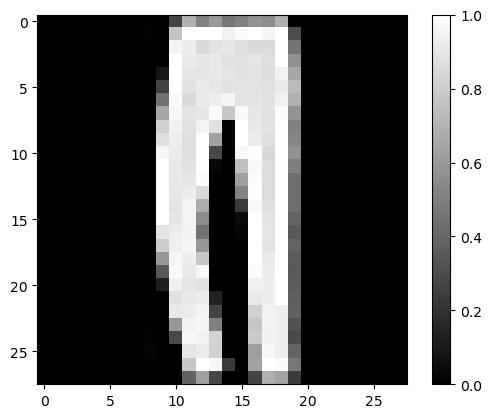

In [39]:
plt.imshow(new_im[0,0],cmap='gray')
plt.colorbar()

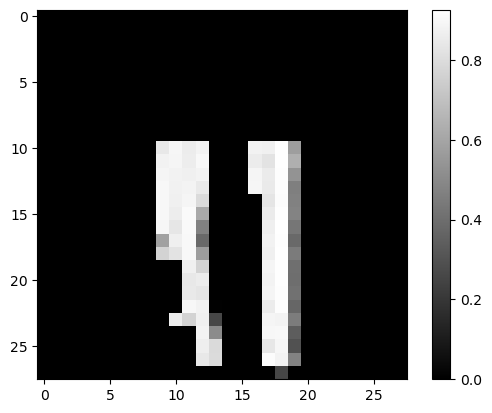

In [40]:
plt.imshow(pred_mu,cmap='gray')
plt.colorbar()

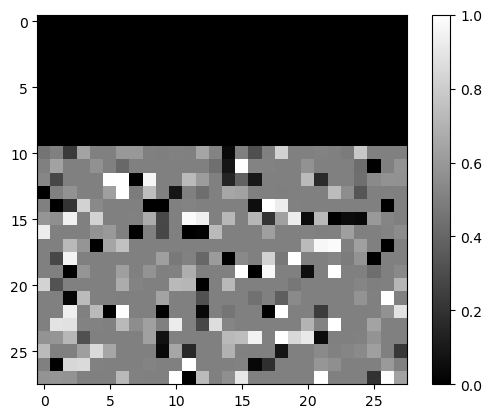

In [41]:
plt.imshow(pred_mu2,cmap='gray')
plt.colorbar()

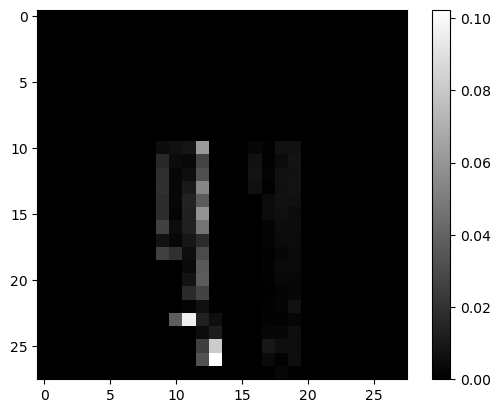

In [42]:
plt.imshow(pred_sigma2,cmap='gray')
plt.colorbar()

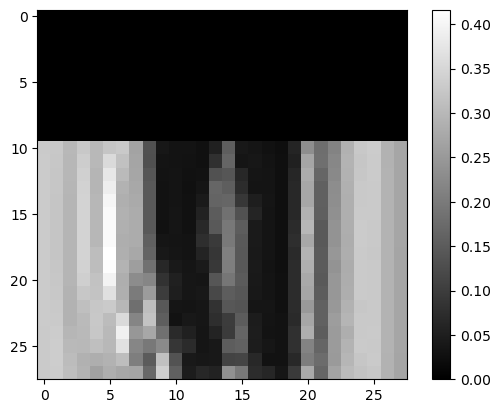

In [43]:
plt.imshow(pred_sigma2_2,cmap='gray')
plt.colorbar()

In [194]:
pixel_cnn(torch.unsqueeze(fashion_imgs_test[0][4:5]/255, dim=0))[0,3:5,4,5].shape

torch.Size([2])